# Probability

## Conditional Probability

### In the Family

Let's assume a family with two unknown children. If we assume that:

1. Each child is equally likely to be a boy/girl.
2. The gender of the second child is independent of the gender of the first child.

What is the probability of "both children are girls" conditional on the event "at least one of the children is a girl."

In [1]:
import random
import math
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
def random_kid():
    return random.choice(["boy","girl"])
both_girls = 0
older_girl = 0
either_girl = 0

random.seed(0)
for _ in range(10000):
    younger = random_kid()
    older = random_kid()
    if older=="girl":
        older_girl +=1
    if older=="girl" and younger == "girl":
        both_girls +=1
    if older == "girl" or younger == "girl":
        either_girl += 1
print ("P(both|older):", both_girls/older_girl)
print ("P(both|either):", both_girls/either_girl)

P(both|older): 0.5007089325501317
P(both|either): 0.3311897106109325


## Continuous Distributions

In [3]:
#the density function for the uniform distribution is:
def uniform_pdf(x):
    return 1 if x >= 0 and x < 1 else 0

In [4]:
#cumulative distribution function
#gives probability that a random variable is less than/equal to a certain value
def uniform_cdf(x):
    if x < 0: return 0
    elif x < 1: return x
    else: return 1

## The Normal Distribution

In [5]:
def normal_pdf(x, mu=0, sigma=1):
    sqrt_two_pi = math.sqrt(2* math.pi)
    return (math.exp(-(x-mu)**2/2/sigma**2)/(sqrt_two_pi*sigma))

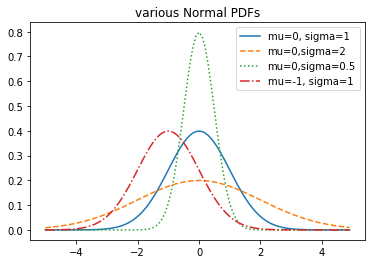

In [6]:
xs = [x/10.0 for x in range(-50, 50)]
plt.plot(xs, [normal_pdf(x, sigma=1) for x in xs], '-', label='mu=0, sigma=1')
plt.plot(xs, [normal_pdf(x, sigma=2)for x in xs], '--',label='mu=0,sigma=2')
plt.plot(xs,[normal_pdf(x,sigma=0.5) for x in xs], ':', label='mu=0,sigma=0.5')
plt.plot(xs, [normal_pdf(x,mu=-1)for x in xs], '-.', label='mu=-1, sigma=1')
plt.legend()
plt.title("various Normal PDFs")
plt.show()

The cumulative distribution function for the normal distribution cannot be written in an "elementary mannger, but we can write is using the following:

In [7]:
def normal_cdf(x, mu=0, sigma=1):
    return (1+math.erf((x-mu)/math.sqrt(2)/sigma))/2

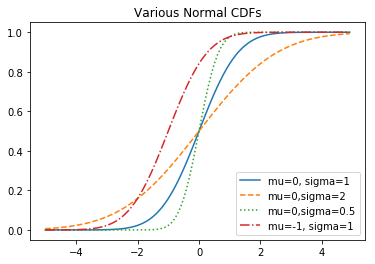

In [8]:
xs = [x/10.0 for x in range(-50, 50)]
plt.plot(xs, [normal_cdf(x, sigma=1) for x in xs], '-', label='mu=0, sigma=1')
plt.plot(xs, [normal_cdf(x, sigma=2)for x in xs], '--',label='mu=0,sigma=2')
plt.plot(xs,[normal_cdf(x,sigma=0.5) for x in xs], ':', label='mu=0,sigma=0.5')
plt.plot(xs, [normal_cdf(x,mu=-1)for x in xs], '-.', label='mu=-1, sigma=1')
plt.legend(loc=4)
plt.title("Various Normal CDFs")
plt.show()

## The Central Limit Theorem

In [9]:
def bernoulli_trial(p):
    return 1 if random.random() < p else 0
def binomial(n,p):
    return sum(bernoulli_trial(p) for _ in range(n))

In [10]:
def make_hist(p, n, num_points):
    data = [binomial(n, p) for _ in range(num_points)]
    histogram = Counter(data)
    plt.bar([x-0.4 for x in histogram.keys()],
           [v/num_points for v in histogram.values()],
           0.8,
           color='0.75')
    mu = p*n
    sigma = math.sqrt(n*p*(1-p))
    
    #line chart
    xs = range(min(data),max(data)+1)
    ys = [normal_cdf(i+0.5, mu,sigma)-normal_cdf(i-0.5, mu,sigma)
         for i in xs]
    plt.plot(xs, ys)
    plt.title("Binomial Dist. vs. Normal Approximation")
    plt.show()

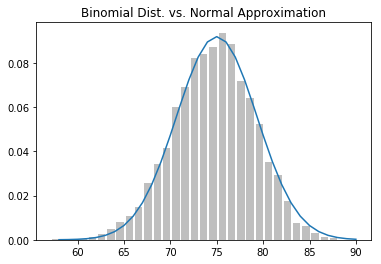

In [11]:
make_hist(0.75, 100, 10000)

# Hypothesis Testing

## Flipping a Coin

In [12]:
import math

Imagine we have a coin and we want to test whether it's fair. Our null hypothesis is that the coin is fair (p=0.5) and our alternative hypothesis is otherwise. 

In particular, out test will involve flipping the coin some number n times and counting the number of heads X. Each coin flip is a Bernoulli trial, which can be approximated using the normal distribution:

In [13]:
def normal_approximation_to_binomial(n, p):
    """finds mu and sigma corresponding to a binomial(n, P)"""
    mu = p*n
    sigma = math.sqrt(p*(1-p)*n)
    return mu, sigma

Whenever a random variable follows a norml distribution, we can use normal_cdf to figure out the probability that its realized value lies within (or outside) a particular interval:

In [14]:
def normal_cdf(x, mu=0, sigma=1):
    return (1+math.erf((x-mu)/math.sqrt(2)/sigma))/2

#the normal cdf is the probability the variable is below a threshold:
normal_probability_below = normal_cdf

#it's above if it's not below the threshold
def normal_probability_above(lo, mu=0, sigma=1):
    return 1-normal_cdf(lo, mu, sigma)
def normal_probability_between(lo, hi, mu=0, sigma=1):
    return normal_cdf(hi, mu, sigma)-normal_cdf(lo, mu, sigma)
def normal_probability_outside(lo, hi, mu=0, sigma=1):
    return 1-normal_probability_between(lo, hi, mu, sigma)

In [15]:
mu_0, sigma_0 = normal_approximation_to_binomial(1000, 0.5)
print(mu_0, sigma_0)

500.0 15.811388300841896


We can also do the reverse, find the nontail region or the interval around the mean that accounts for a certain level of likelihood:

In [16]:
def inverse_normal_cdf(p, mu=0, sigma=1, tolerance=0.00001): 
    """find approximate inverse using binary search"""
# if not standard, compute standard and rescale 
    if mu != 0 or sigma != 1: 
        return mu + sigma * inverse_normal_cdf(p, tolerance=tolerance)
    low_z, low_p = -10.0, 0 
    hi_z, hi_p = 10.0, 1
    while hi_z - low_z > tolerance: 
        mid_z = (low_z + hi_z) / 2 
        mid_p = normal_cdf(mid_z)
        if mid_p < p: # midpoint is still too low, search above it 
            low_z, low_p = mid_z, mid_p
        elif mid_p > p: # midpoint is still too high, search below it 
            hi_z, hi_p = mid_z, mid_p
        else:
            break 
    return mid_z

In [17]:
def normal_upper_bound(probability, mu=0, sigma=1):
    return inverse_normal_cdf(probability, mu, sigma)
def normal_lower_bound(probability, mu = 0, sigma=1):
    return inverse_normal_cdf(1-probability, mu, sigma)
def normal_two_sided_bounds(probability, mu=0, sigma=1):
    tail_probability=(1-probability)/2
    upper_bound = normal_lower_bound(tail_probability, mu,sigma)
    lower_bound = normal_upper_bound(tail_probability, mu, sigma)
    return lower_bound, upper_bound

In [18]:
print(normal_two_sided_bounds(0.95, mu_0, sigma_0))

(469.01026640487555, 530.9897335951244)


We are also often intersted in the power of a test, which is the probability of not making a type 2 error, in which we fail to reject the null even though it's false. We can calculate the power of the test using the following:

In [19]:
#95% bounds based on assumption p is 0.5
lo, hi = normal_two_sided_bounds(0.95, mu_0, sigma_0)

#actual mu and sigma based on p = 0.55
mu_1, sigma_1 = normal_approximation_to_binomial(1000, 0.55)

#if X is still in our original interval, we failed to reject the null
type_2_probability = normal_probability_between(lo, hi, mu_1, sigma_1)
power = 1-type_2_probability
power

0.8865480012953671

Imagine insstead that our null hypothesis was that the coin is not biased toward heads, of that p <= 0.5. In such a case we want a one-sided test that rejects the null hypothesis when X is much larger than 50 but not when X is smaller than 50. So a 5%-significance test involves using normal_probability_below to find the cutoff below which 95% of the probability lies:

In [20]:
hi = normal_upper_bound(0.95, mu_0, sigma_0)
hi

526.0073585242053

In [21]:
type_2_probability = normal_probability_below(hi, mu_1, sigma_1)
power = 1-type_2_probability
power

0.9363794803307173

This is a more power test since it no longer rejects the null when X is below 469 (which is very unlikely to happen if the alternative is true) and instead rejects the null when X is between 526 and 531.

In [22]:
extreme_value_count = 0
for _ in range(100000):
    num_heads=sum(1 if random.random() < 0.5 else 0
                 for _ in range(1000))
    if num_heads >=530 or num_heads <= 470:
        extreme_value_count += 1
print(extreme_value_count/100000)

0.06249


Since the p-value is greater than 5%, we don't reject the null, if we saw instead 532 heads, the p-value would be:

In [23]:
def two_sided_p_value(x, mu=0, sigma=1):
    if x >= mu:
        return 2*normal_probability_above(x, mu,sigma)
    else:
        return 2*normal_probability_below(x,mu,sigma)

In [24]:
two_sided_p_value(531.5, mu_0, sigma_0)

0.046345287837786575

Then we would reject the null.

## Running and A/B Test

In [25]:
def estimated_parameters(N, n):
    p = n/N
    sigma = math.sqrt(p*(1-p)/N)
    return p, sigma

In [28]:
def a_b_test_statistic(N_A, n_A, N_B, n_B):
    p_A, sigma_A = estimated_parameters(N_A, n_A)
    p_B, sigma_B = estimated_parameters(N_B, n_B)
    return (p_B-p_A)/math.sqrt(sigma_A**2+sigma_B**2)

In [31]:
z = a_b_test_statistic(1000,200,1000,180)
z

-1.1403464899034472

In [32]:
z = a_b_test_statistic(1000,200,1000,150)
z

-2.948839123097944

## Bayesian Inference

An alternative approach to inference involves treating the unknowen parameters themselves as random variables. We start with as prior distribution for the parameters and then use the observed data and Bayes's Theorem to get an updated posterior distribution for our parameters.

For example, when the unknowen parameter is a probability (as in the coin-flipping example), we often use a prior from the Beta distribution, which puts all probability between 0 and 1:

In [33]:
def B(alpha, beta):
    return math.gamma(alpha)*math.gamma(beta)/math.gamma(alpha+beta)
def beta_pdf(x, alpha,beta):
    if x < 0 or x > 1:
        return 0
    return x ** (alpha-1)*(1-x)**(beta-1)/B(alpha,beta)